In [1]:
from keras.models import Sequential
from keras.layers import Conv2D,AveragePooling2D,Dropout
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
import numpy as np
import math
import matplotlib.image as mpimg
from pylab import rcParams
from keras.preprocessing import image as kimg
from matplotlib.pyplot import *
import cv2
from imutils.face_utils.helpers import FACIAL_LANDMARKS_IDXS
from imutils.face_utils.helpers import shape_to_np
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import argparse
import imutils
import dlib

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Alert that shows if the CPU or GPU are working
config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Global variables
# Image size
rows = 48
columns = 48
channel = 1

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16516583858216203462
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31588352
locality {
  bus_id: 1
}
incarnation: 8109188575995840694
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [20]:
# Image preprocessing
FLAG_alignment = 'YES' #Enable the Alignment and Cropping preprocessing (when YES, disable when NO).
FLAG_light = 'NO' #Enable the Light Intensity Normalization preprocessing (when YES, disable when NO).
FLAG_not_detected_face = 'NO' #Enable images which face has not been detected (when YES, disable when NO).

# Training configuration
model_file = "models/4.5.2_Aligned+Cropped.h5" #Important to indicate the name in which the new model will be loaded or downloaded.
FLAG_training = 'NO' #Enable the training of the CNN (when TRUE), if not the evaluation process is activated instead.

# Model definition

In [4]:
def CNN_model_definition(rows, columns, channel):
    
    """
       Definition and creation of the Convolutional Neural Network model. It gathers 3 convolution layers,
       3 subsampling layers and 2 fully connected layers.
       
       :param: rows, number of pixels rows of the image.
       :param: columns, number of pixels columns of the image.
       :return: CNN model.
   """
    
    # CNN structure
    model = Sequential()

    # 1st Convolution layer
    model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(rows, columns, channel)))
    model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

    # 2nd Convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))
    
    # 3rd Convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

    model.add(Flatten())

    # Fully Connected layers
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(7, activation='softmax'))
    
    return model

In [5]:
if FLAG_training == 'YES':
    model = CNN_model_definition(rows, columns, channel)
else:
    model = load_model(model_file)

# Image acquisition

In [7]:
def images_acquisition(dataset):
    
    """
       Load of the TRAIN, VALIDATION and TEST sets of the FER2013 database into variables.
       
       :param: dataset, file ".csv" containing the FER2013 dataset.
       :return: x_train, vectors of images of the training set.
       :return: y_train, vector storing the labels associated to the x_train images.
       :return: x_privatetest, vectors of images of the validation set.
       :return: y_privatetest, vector storing the labels associated to the x_privatetest images.
       :return: x_test, vectors of images of the test set.
       :return: x_test, vector storing the labels associated to the x_test images.
   """
        
    x_train, y_train, x_test, y_test, x_privatetest, y_privatetest = [], [], [], [], [], []
    anger, disgust, fear, happiness, sadness, surprise, neutral = 0, 0, 0, 0, 0, 0, 0
    
    with open(dataset) as f:
        content = f.readlines()
        lines = np.array(content)
        num_of_instances = lines.size
        print("Number of images in the FER2013 database: ",num_of_instances)
 
    for i in range(1,num_of_instances):
        try:
            emotion, img, usage = lines[i].split(",")
            val = img.split(" ")
            pixels = np.array(val, 'float32')

            # Counter of the number of instances of each class
            if int(emotion) is 0:
                anger += 1 
            elif int(emotion) is 1:
                disgust += 1
            elif int(emotion) is 2:
                sadness += 1
            elif int(emotion) is 3:
                happiness += 1
            elif int(emotion) is 4:
                fear += 1
            elif int(emotion) is 5:
                surprise += 1
            elif int(emotion) is 6:
                neutral += 1
            
            emotion = keras.utils.to_categorical(emotion, 7)
            
            if 'Training' in usage:
                fu = 55
                #y_train.append(emotion)
                #x_train.append(pixels)
            elif 'PublicTest' in usage:
                y_test.append(emotion)
                x_test.append(pixels)
            else:
                y_privatetest.append(emotion)
                x_privatetest.append(pixels)
                
        except:
            print("Error in the image acquisition process")
            
    print("Number of images belonging to each class:")
    print("Anger: ", anger)
    print("Disgust: ", disgust)
    print("Fear: ", fear)
    print("Happiness: ", happiness)
    print("Sadness: ", sadness)
    print("Surprise: ", surprise)
    print("Neutral: ", neutral)
    
    return x_train, y_train, x_test, y_test, x_privatetest, y_privatetest

def images_reshape(x_train, y_train, x_test, y_test, x_privatetest, y_privatetest, rows, columns, channel):
    
    """
       Transformation of x_train, y_train, x_privatetest, y_privatetest, x_test and y_test into numpy arrays 
       with an especific shape.

       :param: x_train, vectors of images of the training set.
       :param: y_train, vector storing the labels associated to the x_train images.
       :param: x_test, vectors of images of the test set.
       :param: y_test, vector storing the labels associated to the x_test images.
       :param: x_privatetest, vectors of images of the validation set.
       :param: y_privatetest, vector storing the labels associated to the x_privatetest images.
       :param: rows, number of pixels rows of the image.
       :param: columns, number of pixels columns of the image.
       :params: channel, indicates the color type of the image, channel = 1 indicates grayscale and channel = 3 rgb.
       :return: x_train, reshaped array of images of the training set.
       :return: y_train, reshaped array storing the labels associated to the x_train images.
       :return: x_privatetest, reshaped array array of images of the validation set.
       :return: y_privatetest, reshaped array storing the labels associated to the x_privatetest images.
       :return: x_test, reshaped array of images of the test set.
       :return: x_test, reshaped array storing the labels associated to the x_test images.
   """
        
    x_train = np.array(x_train, 'float32')
    y_train = np.array(y_train, 'float32')
    x_test = np.array(x_test, 'float32')
    y_test = np.array(y_test, 'float32')
    x_privatetest = np.array(x_privatetest, 'float32')
    y_privatetest = np.array(y_privatetest, 'float32')

    x_train = x_train.reshape(x_train.shape[0], rows, columns, channel)
    x_train = x_train.astype('float32')
    x_test = x_test.reshape(x_test.shape[0], rows, columns, channel)
    x_test = x_test.astype('float32')
    x_privatetest = x_privatetest.reshape(x_privatetest.shape[0], rows, columns, channel)
    x_privatetest = x_privatetest.astype('float32')

    print('Shape of x_train:', x_train.shape)
    print('Shape of x_test:', x_test.shape)
    print('Shape of x_privatetest:', x_privatetest.shape)
    
    return x_train, y_train, x_test, y_test, x_privatetest, y_privatetest

In [8]:
x_train, y_train, x_test, y_test, x_privatetest, y_privatetest = images_acquisition("fer2013.csv")
x_train, y_train, x_test, y_test, x_privatetest, y_privatetest = images_reshape(x_train, y_train, x_test, y_test, x_privatetest, y_privatetest, rows, columns, channel)

('Number of images in the FER2013 database: ', 35888)
Number of images belonging to each class:
('Anger: ', 4953)
('Disgust: ', 547)
('Fear: ', 6077)
('Happiness: ', 8989)
('Sadness: ', 5121)
('Surprise: ', 4002)
('Neutral: ', 6198)
('Shape of x_train:', (0, 48, 48, 1))
('Shape of x_test:', (3589, 48, 48, 1))
('Shape of x_privatetest:', (3589, 48, 48, 1))


# Image Preprocessing - Alignment, Cropping & Light Intensity Normalization

In [9]:
def zoom_alignment(gray, rect, predictor): 

    """
       Alienation of a picture respect to the face.

        :param: desiredFaceWidth, rows of the image
        :param: desiredFaceHeight, columns of the image
        :param: gray, conversion of the image to grayscale
        :param: rect, facial region of the detected face
        :return: Picture with the face aligned.

   """

    # Customizable parameters
    desiredLeftEye=(0.24, 0.26) #24,#26 #0.28,0.28, when no cropping
    desiredFaceWidth=rows
    desiredFaceHeight=columns
    
    # Use an existent predictor
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)

    # Obtain the left and right eyes (x,y) coordinates
    (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]

    # Compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

    # Compute the angle between the eye centroids
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX)) - 180

    # Compute the desired right eye x-coordinate based on the desired x-coordinate of the left eye
    desiredRightEyeX = 1.0 - desiredLeftEye[0]

    # Determine the scale of the new resulting image by taking the ratio of the distance between eyes
    # in the *current* image to the ratio of distance between eyes in the *desired* image
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= desiredFaceWidth
    scale = desiredDist / dist

    # Compute center (x, y)-coordinates between the two eyes in the input image
    eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
    (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

    # Grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

    # Update the translation component of the matrix
    tX = desiredFaceWidth * 0.5
    tY = desiredFaceHeight * desiredLeftEye[1]
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])

    # Apply the affine transformation
    (w, h) = (desiredFaceWidth, desiredFaceHeight)
    output = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC) 

    return output

def several_faces_zoom_alignment(image, detector, predictor):
 
    """
       Face alineation and cropping, for every face detected into a single picture.

        :param: image, picture in which the faces are recognizes.
        :param: detector, already trained detector.
        :param: predictor, already trained predictor.
        :return: One picture per face cropped and aligned.

   """
    
    image = np.array(image, dtype = np.uint8)
    faces = detector(image, 2)
    face_ready = 'null'
    
    # For each face recognized in the picture
    for face in faces:

        (x, y, w, h) = rect_to_bb(face)
        face_ready = zoom_alignment(image, face, predictor)
        face_ready = np.concatenate(face_ready)
        face_ready = np.array(face_ready, 'float32')
 
    return face_ready

def images_modified1(x_train, y_train, x_test, y_test, x_privatetest, y_privatetest, rows, columns, channel):
    
    """
       Face alineation and cropping

        :param: x_train&y_train, set of pictures of the training set and their associated labels.
        :param: x_test&y_test, set of pictures of the test set and their associated labels.
        :param: x_privatetest&y_privatetest, set of pictures of the privatetest set and their associated labels.
        :param: rows, number of pixels rows of the image.
        :param: columns, number of pixels columns of the image.
        :params: channel, indicates the color type of the image, channel = 1 indicates grayscale and channel = 3 rgb.
        :return: x_train_modified, set of pictures aligned and cropped.
        :return: x_test_modified, set of pictures aligned and cropped.
        :return: x_privatetest_modified, set of pictures aligned and cropped.

   """
    
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    x_train_modified, x_test_modified, x_privatetest_modified = [], [], []
    y_train_modified, y_test_modified, y_privatetest_modified = y_train, y_test, y_privatetest
    num_non_detected_TRAIN, num_non_detected_TEST, num_non_detected_PTEST = 0, 0, 0
    
    i=0
    for image in x_train:
        new = several_faces_zoom_alignment(image, detector, predictor)

        if new is 'null':
            
            # Descarting images in which no face has been recognized
            if FLAG_not_detected_face == 'NO':
                num_non_detected_TRAIN += 1
                # Deleting the associated label
                y_train_modified=np.delete(y_train_modified, i, axis=0)
            
            else:
                image = cv2.resize(image, (rows, columns)) 
                image = np.concatenate(image)
                image = np.array(image, 'float32')

                x_train_modified.append(image)
        else:
            x_train_modified.append(new)
            i += 1

    i=0
    for image in x_test:
        new = several_faces_zoom_alignment(image, detector, predictor)
        
        if new is 'null':     
            # Descarting images in which no face has been recognized
            if FLAG_not_detected_face == 'NO':
                num_non_detected_TEST += 1
                # Deleting the associated label
                y_test_modified=np.delete(y_test_modified, i, axis=0)
            
            else:
                image = cv2.resize(image, (rows, columns)) 
                image = np.concatenate(image)
                image = np.array(image, 'float32')

                x_test_modified.append(image)

        else:
            x_test_modified.append(new)
            i += 1
    
    i=0
    for image in x_privatetest:
        new = several_faces_zoom_alignment(image, detector, predictor)
        
        if new is 'null':     
            # Descarting images in which no face has been recognized
            if FLAG_not_detected_face == 'NO':
                num_non_detected_PTEST += 1
                # Deleting the associated label
                y_privatetest_modified=np.delete(y_privatetest_modified, i, axis=0)
            
            else:
                image = cv2.resize(image, (rows, columns)) 
                image = np.concatenate(image)
                image = np.array(image, 'float32')

                x_privatetest_modified.append(image)
        else:
            x_privatetest_modified.append(new)
            i += 1
    
    if FLAG_not_detected_face == 'YES':
        y_train_modified = y_train
        y_test_modified = y_test
        y_privatetest_modified = y_privatetest
    
    x_train_modified = np.array(x_train_modified, dtype='float32')
    x_test_modified = np.array(x_test_modified, dtype='float32')
    x_privatetest_modified = np.array(x_privatetest_modified, dtype='float32')
    x_train_modified = x_train_modified.reshape(x_train_modified.shape[0], rows, columns, channel)
    x_test_modified = x_test_modified.reshape(x_test_modified.shape[0], rows, columns, channel)
    x_privatetest_modified = x_privatetest_modified.reshape(x_privatetest_modified.shape[0], rows, columns, channel)
             
    print("Descarted images of TRAIN: ",num_non_detected_TRAIN, float(num_non_detected_TRAIN)/float(len(x_train)+0.01))
    print("Descarted images of TEST: ",num_non_detected_TEST, float(num_non_detected_TEST)/float(len(x_test)+0.01))
    print("Descarted images of privatetest: ",num_non_detected_PTEST, float(num_non_detected_PTEST)/float(len(x_privatetest)+0.01))
   
    return x_train_modified, y_train_modified, x_test_modified, y_test_modified, x_privatetest_modified, y_privatetest_modified

def standard_deviation(img, meanPoint, point, kSize):
    
    """
        Face alineation and cropping

        :param: x_train&y_train, set of pictures of the training set and their associated labels.
        :param: x_privatetest&y_privatetest, set of pictures of the privatetest set and their associated labels.
        :param: x_test$y_test, set of pictures of the test set and their associated labels.
        :param: rows, number of pixels rows of the image.
        :param: columns, number of pixels columns of the image.
        :params: channel, indicates the color type of the image, channel = 1 indicates grayscale and channel = 3 rgb.
        :return: x_train_modified, set of pictures aligned and cropped.
        :return: x_test_modified, set of pictures aligned and cropped.
        :return: x_privatetest_modified, set of pictures aligned and cropped.

    """
        
    kSizeX, kSizeY = kSize / 2, kSize / 2

    ystart = point[1] - kSizeY if 0 < point[1] - kSizeY < img.shape[0] else 0
    yend = point[1] + kSizeY + 1 if 0 < point[1] + kSizeY + 1 < img.shape[0] else img.shape[0] - 1

    xstart = point[0] - kSizeX if 0 < point[0] - kSizeX < img.shape[1] else 0
    xend = point[0] + kSizeX + 1 if 0 < point[0] + kSizeX + 1 < img.shape[1] else img.shape[1] - 1

    patch = (img[ystart:yend, xstart:xend] - meanPoint) ** 2
    total = np.sum(patch)
    n = patch.size

    return 1 if total == 0 or n == 0 else np.sqrt(total / float(n))


def light_intensity_normalization(img, kSize):
    
    """
        Transform the light intensity of the image performing a contrastive equalization.

        :param: img, original image.
        :param: k_size, kernel size.
        :return: Image with the normalization process applied.

   """
        
    blur = cv2.GaussianBlur(img, (kSize, kSize), 0, 0).astype(np.float64)
    newImg = np.ones(img.shape, dtype=np.float64) * 127

    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            original = img[y, x]
            gauss = blur[y, x]
            desvio = standard_deviation(img, gauss, [x, y], kSize)

            novoPixel = 127
            if desvio > 0:
                novoPixel = (original - gauss) / float(desvio)

            newVal = np.clip((novoPixel * 127 / float(2.0)) + 127, 0, 255)
            newImg[y, x] = newVal
    return newImg

def images_modified2(x_train, x_test, x_privatetest, rows, columns, channel):
    
    x_train_modified, x_test_modified, x_privatetest_modified = [], [], []
    for image in x_train:
        
        image = light_intensity_normalization(image, 7)
        x_train_modified.append(image)

    for image in x_test:
        
        image = light_intensity_normalization(image, 7)
        x_test_modified.append(image)
        
    for image in x_privatetest:
        
        image = light_intensity_normalization(image, 7)
        x_privatetest_modified.append(image)
    
    x_train_modified = np.array(x_train_modified, dtype='float32')
    x_test_modified = np.array(x_test_modified, dtype='float32')
    x_privatetest_modified = np.array(x_privatetest_modified, dtype='float32')
   
    x_train_modified = x_train_modified.reshape(x_train_modified.shape[0], rows, columns, channel)
    x_test_modified = x_test_modified.reshape(x_test_modified.shape[0], rows, columns, channel)
    x_privatetest_modified = x_privatetest_modified.reshape(x_privatetest_modified.shape[0], rows, columns, channel)
    
    return x_train_modified, x_test_modified, x_privatetest_modified

In [21]:
x_privatetest, y_privatetest = [], []#Comment to have an extra test set
if FLAG_alignment == 'YES':
    x_train_modified, y_train_modified, x_test_modified, y_test_modified, x_privatetest_modified, y_privatetest_modified = images_modified1(x_train, y_train, x_test, y_test, x_privatetest, y_privatetest, rows, columns, channel)
    if FLAG_light == 'YES':
        x_train_modified, x_test_modified, x_privatetest_modified = images_modified2(x_train_modified, x_test_modified, x_privatetest_modified, rows, columns, channel)
else:
    if FLAG_light == 'YES':
        x_train_modified, x_test_modified, x_privatetest_modified = images_modified2(x_train, x_test, x_privatetest, rows, columns, channel)
    else:
        x_train_modified = x_train
        x_test_modified = x_test
        x_privatetest_modified = x_privatetest
    y_train_modified = y_train
    y_test_modified = y_test
    y_privatetest_modified = y_privatetest

('Descarted images of TRAIN: ', 0, 0.0)
('Descarted images of TEST: ', 1093, 0.3045408065176748)
('Descarted images of privatetest: ', 0, 0.0)


# Visual examples of an image test batch

In [11]:
def images_batch(ims, figsize=(20,10), rows=3, interp=False, titles=None):
    
    """
       Graphic visualization of batches of images, with 20x10 image size and 3 rows of images.
       
       :param: ims, dataset of images to show
       :param: figsize, individual image dimension to show
       :param: rows, number of rows of images to show
       :param: interp, boolean indication possible interpolation
       :param: titles, additional labels above each image.

   """
        
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i].squeeze(), cmap=matplotlib.cm.gray)
        
def get_class_text(labels):
    
    """
        Obtain the emotion associated to numeric labels.

        :param: labels, array of numeric label.
        :return: Array containing all the textual emotions associated to the numeric labels.

   """
    new_class = []
    i = 0
    
    while i < len(labels):
        if labels[i][0] == 1:
            new_class.append('Anger')
        elif labels[i][1] == 1:
            new_class.append('Disgust')
        elif labels[i][2] == 1:
            new_class.append('Fear')
        elif labels[i][3] == 1:
            new_class.append('Happiness')
        elif labels[i][4] == 1:
            new_class.append('Sadness')
        elif labels[i][5] == 1:
            new_class.append('Surprise')
        elif labels[i][6] == 1:
            new_class.append('Neutral')
        i = i+1
    return new_class

### Original Dataset

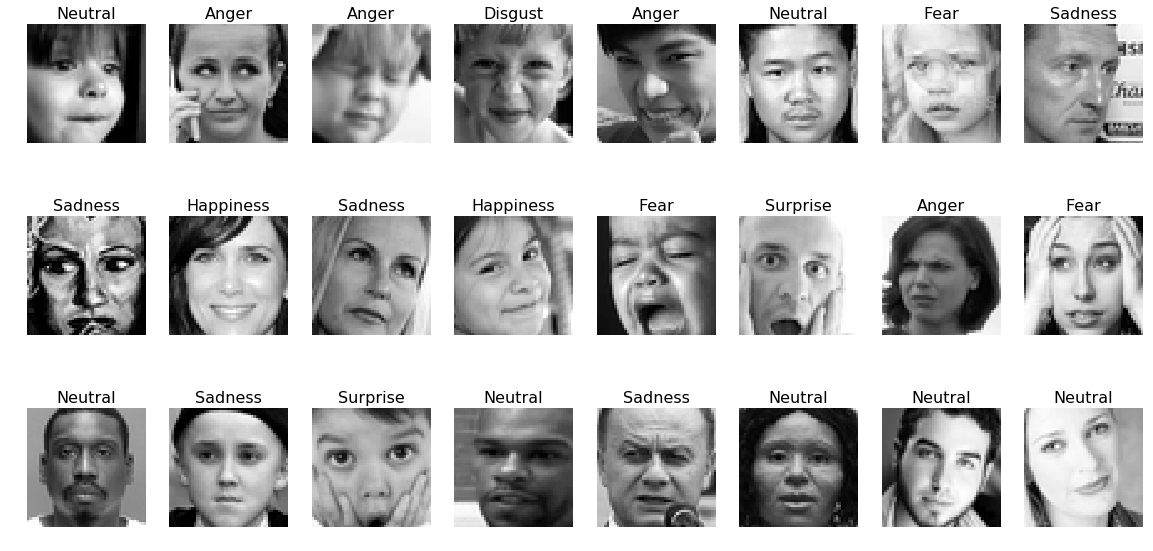

In [12]:
gen = ImageDataGenerator()
test_generator = gen.flow(x_test, y_test, batch_size=24) 
test_imgs, test_labels = next(test_generator)
test_labels_text = get_class_text(test_labels)
images_batch(test_imgs, titles= test_labels_text)

### Aligned, Cropped and Light Intensity Normalized Dataset

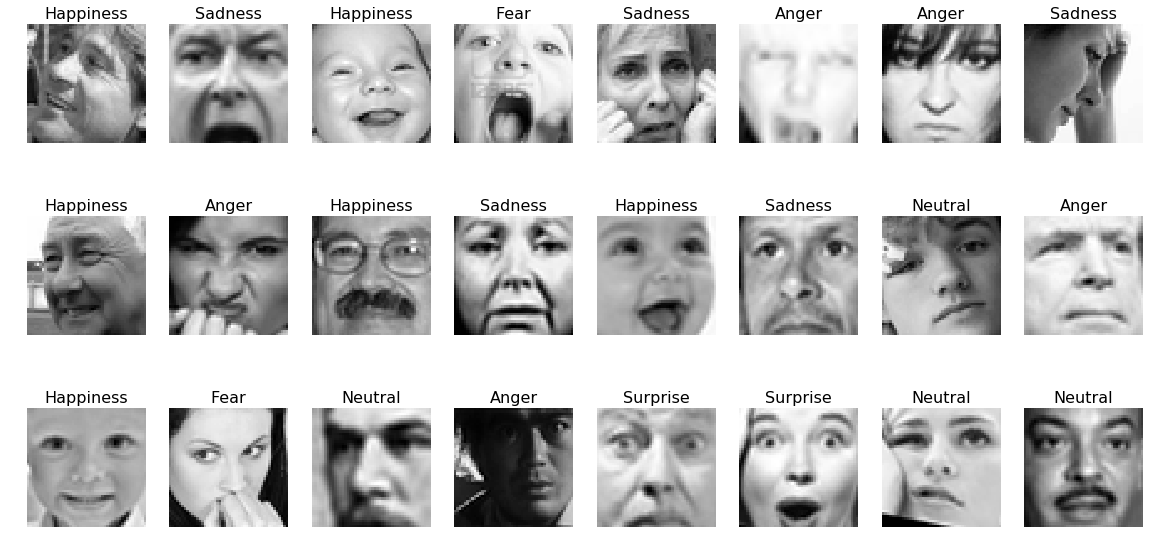

In [13]:
gen = ImageDataGenerator()
test_generator = gen.flow(x_test_modified, y_test_modified, batch_size=24) 
test_imgs, test_labels = next(test_generator)
test_labels_text = get_class_text(test_labels)
images_batch(test_imgs, titles= test_labels_text)

# Training

In [14]:
def images_normalization(x_train, x_test):
    """
       Normalize image vectors between [0, 1]

       :param: x_train, vectors of images of the training set without normalizing.
       :param: x_test, vectors of images of the test set without normalizing.
       :param: x_privatetest, vectors of images of the alternative set without normalizing.
       :return: x_train, vectors of images of the training set normalized.
       :return: x_test, vectors of images of the test set normalized.
       :return: x_privatetest, vectors of images of the alternative set normalized.
    """

    x_train = x_train/255
    x_test = x_test/255
    
    return x_train, x_test

def CNN_training(model, x_train_modified, y_train_modified, batch_size, steps_per_epoch, epochs, model_file):
    """
       CNN training phase.
       
       :param: model, CNN model to be trained.
       :param: x_train_modified, training set, croppped, aligned and light normalized.
       :param: y_train_modified, labels of the training set.
       :param: batch_size, number of images that the model will receive per epoch.
       :param: steps_per_epoch, number of steps per epoch (one per image of the batch).
       :param: epochs, number of batches to train.
       :param: model_file, name of the file in which the CNN model will be stored.
   """
    gen = ImageDataGenerator()
    train_generator = gen.flow(x_train_modified, y_train_modified, batch_size)
    #validation_generator = gen.flow(x_validation_modified, y_validation)
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    model.fit_generator(train_generator, steps_per_epoch, epochs) #steps_per_epoch,validation_data = validation_generator
    
    # Saving the model structure into an external file
    model.save(model_file)

In [22]:
x_train_modified, x_test_modified = images_normalization(x_train_modified, x_test_modified)
if FLAG_training == 'YES':
    CNN_training(model, x_train_modified, y_train_modified, 256, 256, 19, model_file)

# Evaluation

In [16]:
def get_prediction_number(probabilities):
    """
       Choose the class with highest probability, storing in a new array 
       the categorical number representing the class.
       
       :param: probabilities, array with the resulting predictions returned by the *predict* method of Keras.
       :return: New array containing categorical numbers, the new labels of the x_test images.

   """
    new_class = []
    i = 0
    while i < len(probabilities):
        highest = max(probabilities[i])
        if probabilities[i][0] == highest:
            new_class.append(0)
        elif probabilities[i][1] == highest:
            new_class.append(1)
        elif probabilities[i][2] == highest:
            new_class.append(2)
        elif probabilities[i][3] == highest:
            new_class.append(3)
        elif probabilities[i][4] == highest:
            new_class.append(4)
        elif probabilities[i][5] == highest:
            new_class.append(5)       
        elif probabilities[i][6] == highest:
            new_class.append(6)
        elif probabilities[i][7] == highest:
            new_class.append(7)
        i = i+1
    return new_class

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Print and plot the confusion matrix of the predictions

    :param: probabilities, array with the resulting predictions returned by the *predict* method of Keras.
    :return: New array containing categorical numbers, the new labels of the x_test images.

    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_confusion_matrix(model, test_set, test_labels, title):
    
    """
        Print and plot the confusion matrix of the predictions

        :param: probabilities, array with the resulting predictions returned by the *predict* method of Keras.
        :return: New array containing categorical numbers, the new labels of the x_test images.

    """
    
    predictions = model.predict(test_set)
    predicted_labels = get_prediction_number(predictions)
    test_labels = get_prediction_number(test_labels)
    
    cm = confusion_matrix(predicted_labels, test_labels)
    cm_plot_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']
    np.set_printoptions(precision=4)
    plt.figure()
    plot_confusion_matrix(cm, cm_plot_labels, title=title)
    
    return predicted_labels, test_labels

# Accuracy

In [23]:
#train_score = model.evaluate(x_train_modified, y_train_modified, verbose=0)
test_score = model.evaluate(x_test_modified, y_test_modified, verbose=0)
#print('Train loss:', train_score[0])
#print('Train accuracy:', 100*train_score[1])

print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

('Test loss:', 2.5638418274048047)
('Test accuracy:', 61.458333333333336)


### Train

Confusion matrix, without normalization
[[3530   21  230   75  269   25  197]
 [  37  396   29    5    6    8    1]
 [ 115   12 3318   68  202  183   63]
 [  22    2   25 6923   33   80  126]
 [ 193    3  372   40 4111   19  406]
 [   3    2   58   10    2 2838    1]
 [  95    0   65   94  207   18 4171]]


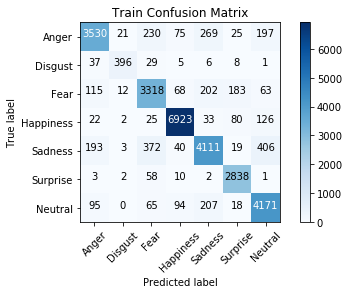

In [20]:
predicted_labels, test_labels = get_confusion_matrix(model, x_train_modified, y_train_modified, 'Train Confusion Matrix')

### Test

Confusion matrix, without normalization
[[235  24  74  58 106  19  80]
 [ 15  25   7   0   7   1   0]
 [ 70   1 196  40  82  57  49]
 [ 30   0  22 683  44  23  56]
 [ 69   5 104  39 319  11 131]
 [  9   0  38  11  12 287  11]
 [ 39   1  55  64  83  17 280]]


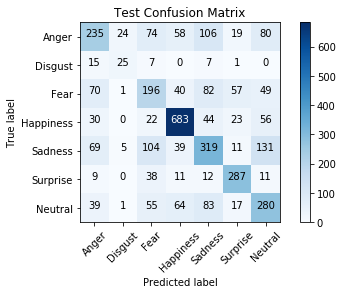

In [21]:
predicted_labels, test_labels = get_confusion_matrix(model, x_test_modified, y_test_modified, 'Test Confusion Matrix')

# Testing Model

#### Checking for images wrongly classified

In [ ]:
def get_prediction_text(x):
    
    """
        Given an estocastical number, return its associated textual emotion.

        :param: x, estocastical number related to an emotion.
        :return: Name of the emotion.

    """
    
    if x is 0:
        return 'Anger'
    elif x is 1:
        return 'Disgust'
    elif x is 2:
        return 'Sadness'
    elif x is 3:
        return 'Happiness'
    elif x is 4:
        return 'Fear'
    elif x is 5:
        return 'Surprise'
    elif x is 6:
        return 'Neutral'
    
def wrongly_classified_images(num_set, test_set, test_labels, prediction_labels):
    
    """
        Show the images wrongly classified.

        :param: x, estocastical number related to an emotion.

    """

    i = 0
    image_number = 50
    wrong_images, wrong_images_text = [], []
    
    while i < num_set and image_number < len(test_set):
        
        original_label = get_prediction_text(test_labels[image_number])
        predicted_label = get_prediction_text(prediction_labels[image_number])
        
        # Finding worngly classified.
        if original_label != predicted_label:
            text = (original_label, predicted_label)
            wrong_images.append(test_set[image_number])
            wrong_images_text.append(text)
            i += 1
        image_number += 1
        
    print("First position: Original label")
    print("Second position: Predicted label")
    images_batch(wrong_images, titles= wrong_images_text)

In [ ]:
wrongly_classified_images(12, x_test_modified, test_labels, predicted_labels)